In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import re 
from operator import itemgetter
import warnings
from scipy.integrate import solve_ivp
from scipy import optimize
import seaborn as sns
import PyCCELL_PRFQT as px
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

C:\Users\nessl\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


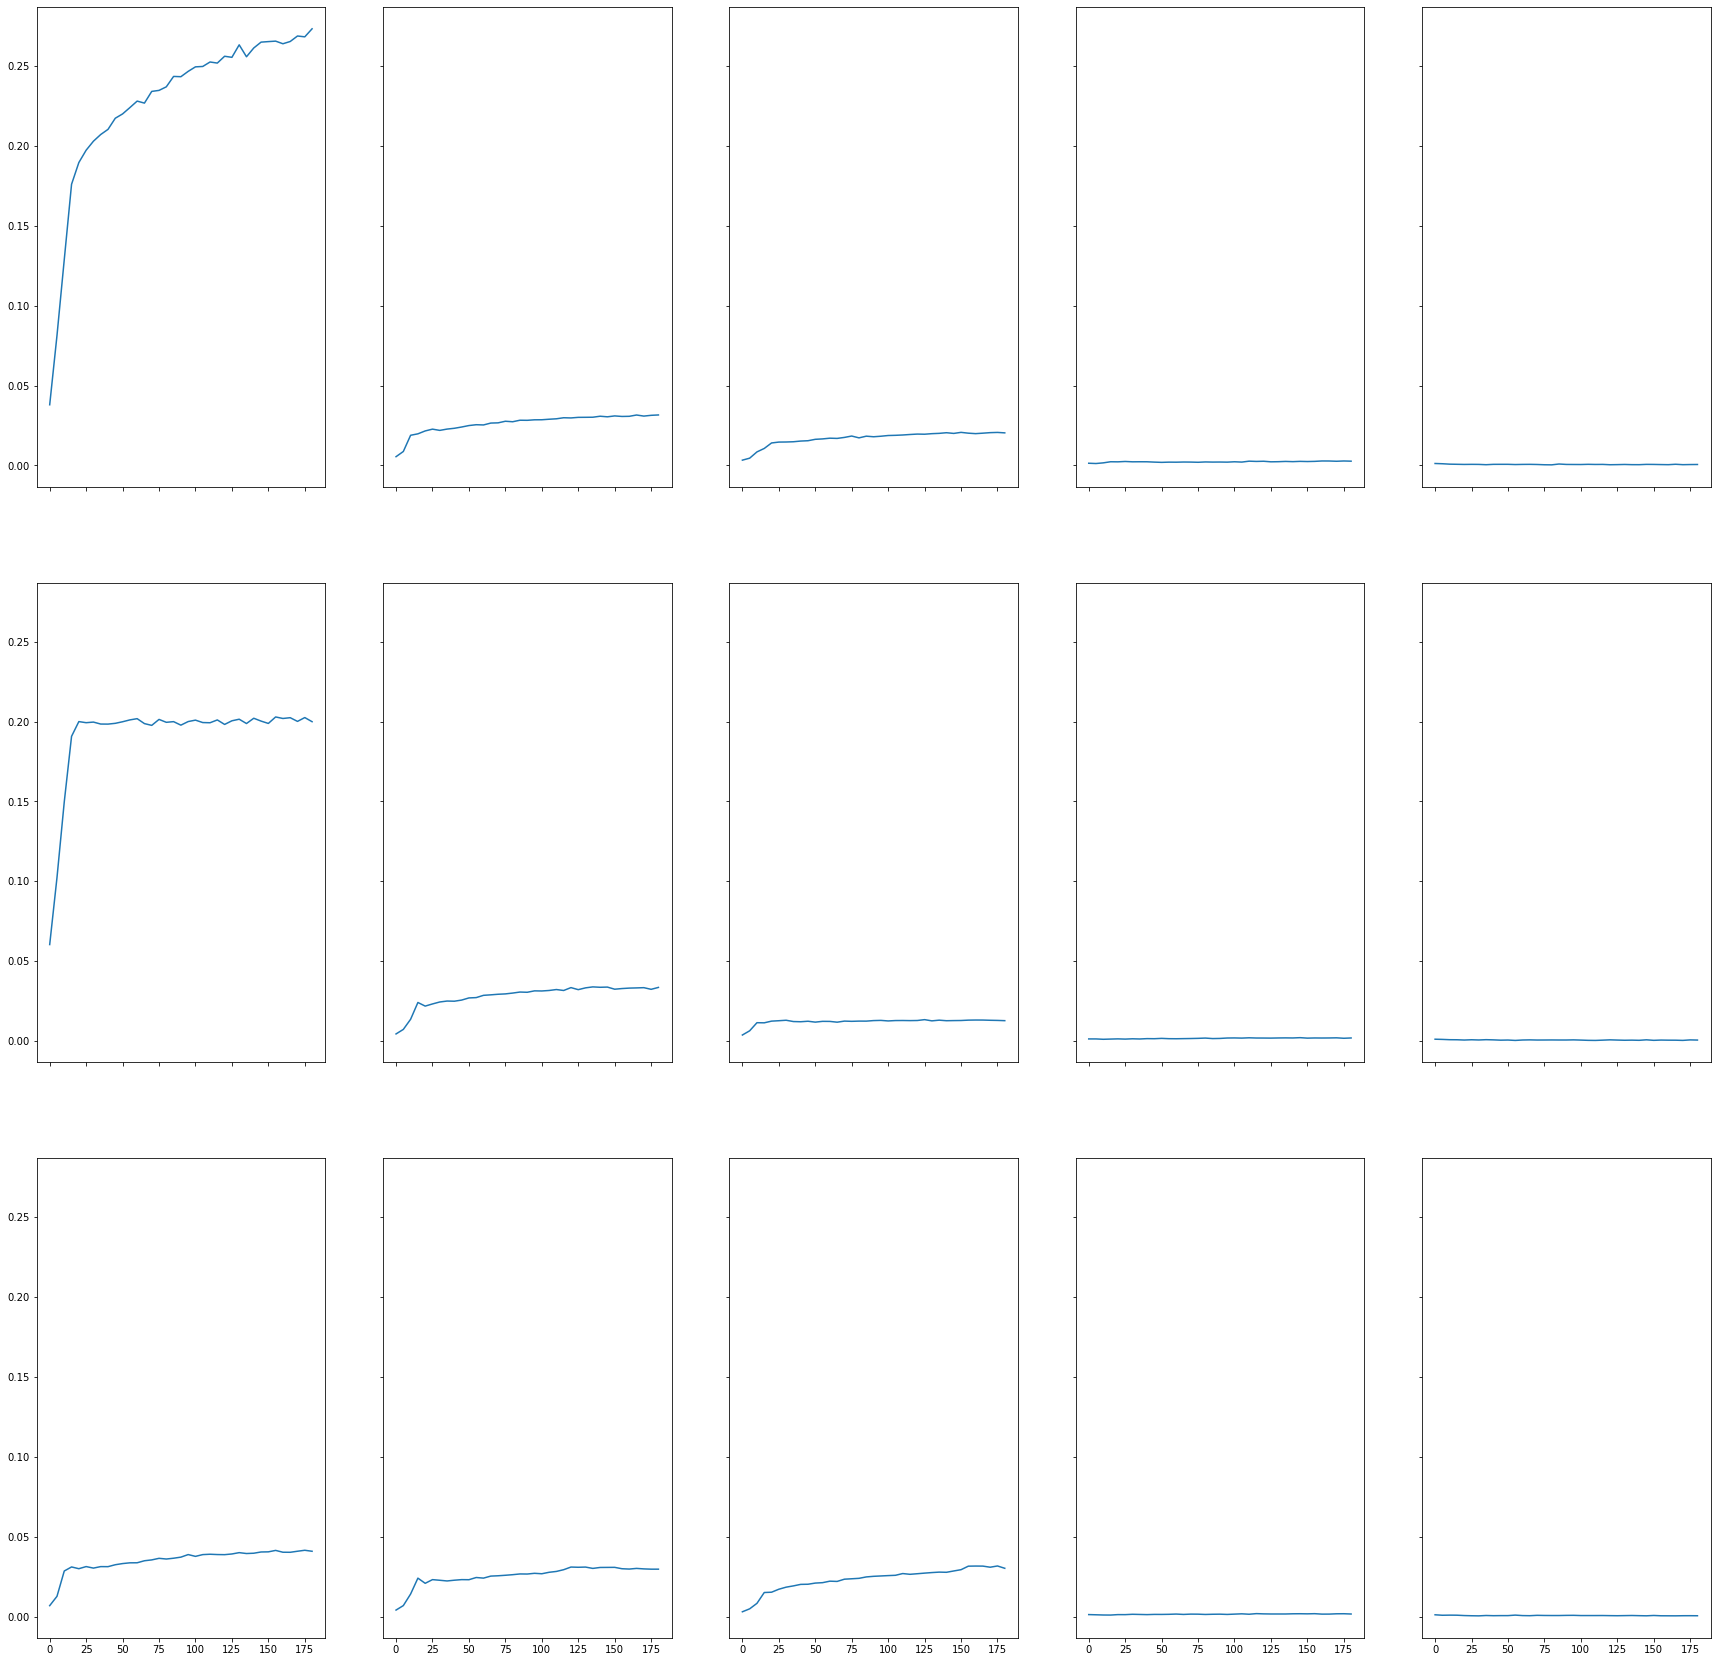

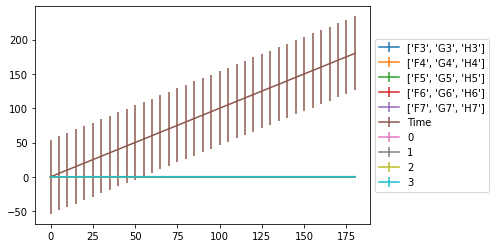

In [9]:
test = px.main('../results/SHERLOCK/1st_try_probe_dilution/sherlock_probe_concentr_2.xlsx'
               ,70,"YES",3,5,'col',['F7','G7','H7'],"YES")


In [10]:
test.rename(columns={"['F3', 'G3', 'H3']": '2µM_P_Cold',
                   "['F4', 'G4', 'H4']": '2µM_P',
                     "['F5', 'G5', 'H5']":'1µM_P' ,
                     "['F6', 'G6', 'H6']": '0.1µM_P',
                    "['F7', 'G7', 'H7']": 'NC_wt_cas',
                     0: '2µM_P_Cold_std',
                   1: '2µM_P_std',
                     2:'1µM_P_std' ,
                     3: '0.1µM_P_std',
                    4: 'NC_wt_cas_std'},
          inplace=True, errors='raise')

test.head()

,2µM_P_Cold,2µM_P,1µM_P,0.1µM_P,NC_wt_cas,Time,2µM_P_Cold_std,2µM_P_std,1µM_P_std,0.1µM_P_std,NC_wt_cas_std
0,0.033913,0.003507,0.002200,0.000150,0.0,0,0.021953,0.000595,0.000305,0.000050,0.000041
1,0.064480,0.006657,0.004302,0.000242,0.0,5,0.038277,0.000797,0.000808,0.000071,0.000096
2,0.101565,0.014708,0.008569,0.000386,0.0,10,0.052915,0.002371,0.001451,0.000275,0.000045
3,0.131844,0.021871,0.011575,0.000703,0.0,15,0.072056,0.002032,0.001939,0.000584,0.000064
4,0.139244,0.020806,0.013297,0.000979,0.0,20,0.077820,0.000433,0.001154,0.000458,0.000014


In [6]:
def syst2(t,z,param):
    
    Tu,Pa,Pi,Tc = z
    
    GC,K1,K2,K3,K4,Km = param  
    
    dTudt = -(K1*GC*Tu)
    
    #dPadt = (K3*Tu*GC*Pi)/(Km+Tu)
    dPadt = (K3*GC*Pi)/(Km+Pi)

    dPidt = -dPadt
    
    dTcdt = (K4*Tu*GC)/(Km+Tu)
        
    return [dTudt,dPadt,dPidt,dTcdt]

def error(param,obs):
    
    times = np.linspace(0,35,35)
    t = np.linspace(0,500,500)
    
    sol = solve_ivp(syst2,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    m = sol.sol(times)
    
    err = []
        
    for i in range(len(m.tolist()[3])):
        err.append((obs[i]-m.tolist()[3][i])**2)    
    
    erro = np.sum(err)
    '''
    if erro < 0.05:
        print(erro)
    '''
    return erro

In [172]:
Tu = 0.001
Pa = 0.02
Pi = 2
Tc = 0.001
GC = 0.4 
K1 = 0.1
K2 = 0.05
K3 = 1
K4 = 0.1
Km = 500

z = [Tu,Pa,Pi,Tc]
param  = [GC,K1,K2,K3,K4,Km]

bnds = [(0.3,0.43),(0.0001,1),(0.0001,1),(0.0001,1),(0.00001,0.1),(0.001,1000)]
res = optimize.minimize(error, param, args=(list(test[test.columns[0]])),bounds=bnds,method='Nelder-Mead')

In [173]:
res.x

array([4.30000000e-01, 4.03061348e-01, 1.00000000e-04, 1.00000000e+00,
       1.00000000e-01, 1.00000000e-03])

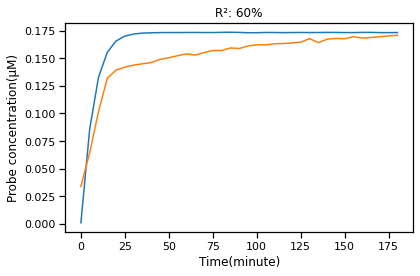

In [188]:
times = np.linspace(0,180,37)

sol = solve_ivp(syst2,t_span =[0, times.max()], y0= z , args =([res.x]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)
r = r2_score(test[test.columns[0]],m[3])


sns.set_context('notebook')
sns.set_palette("tab10")

plt.plot(times,m[3])
plt.plot(times,test[test.columns[0]])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title('R²: '+str(round(r*100))+'%')
plt.tight_layout()
#plt.savefig("images/SHERLOCK/modeling/first_attempt.png",dpi=300)
plt.show()

### Try on another experiment

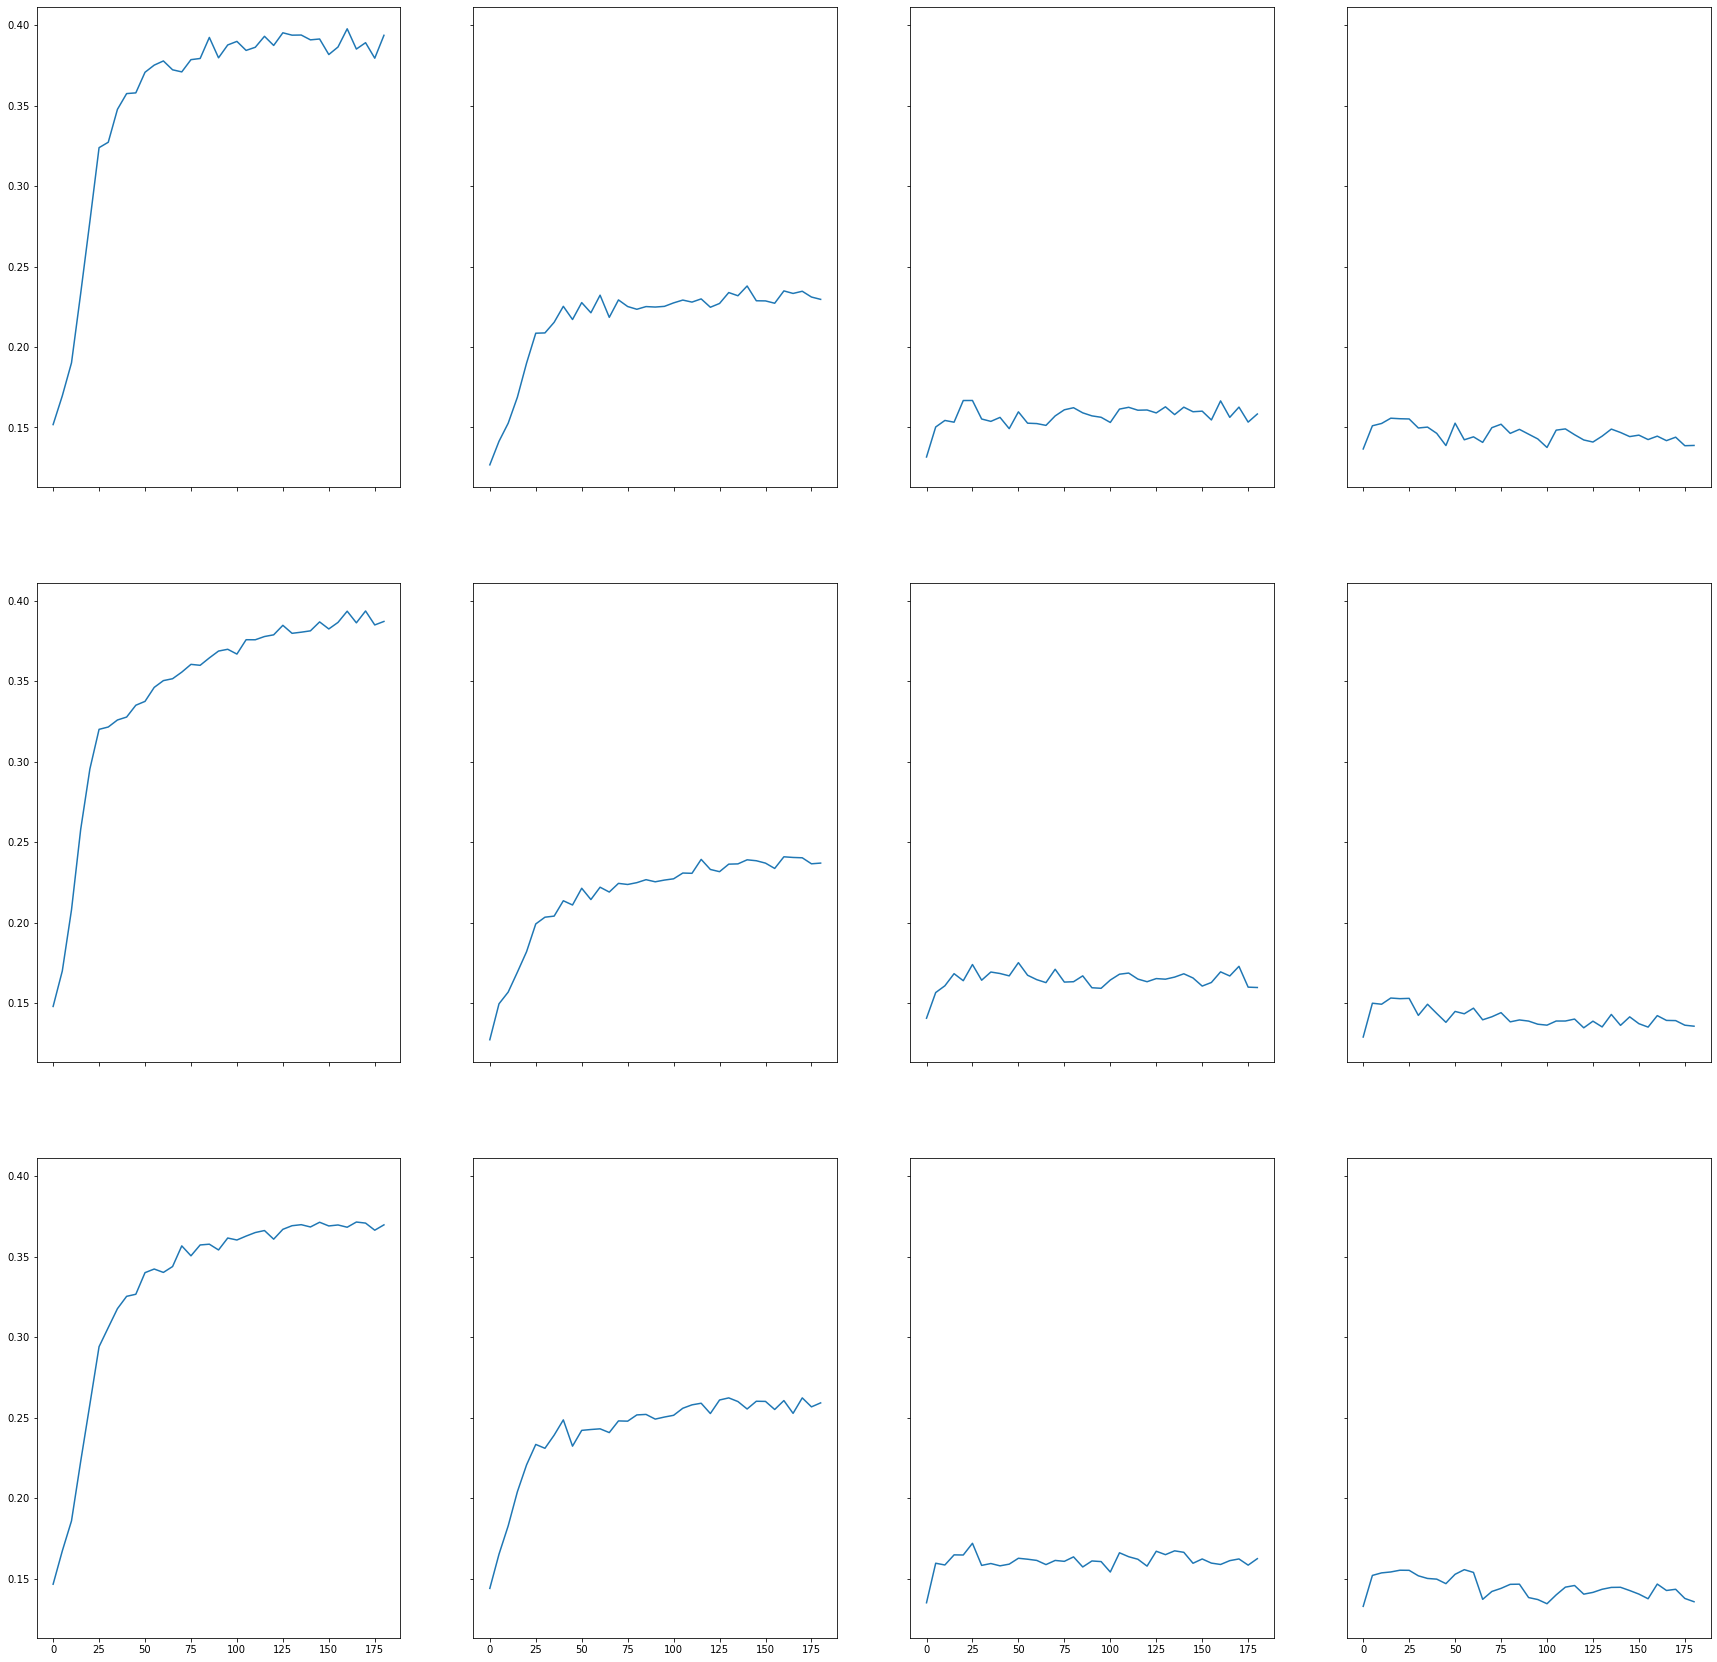

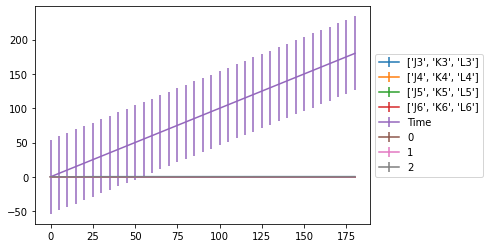

In [3]:
test_2 = px.main('../results/SHERLOCK/1st_try_probe_dilution/sherlock_probe_concentr_3_v2.xlsx',
               75,"YES",3,4,'col',['J6','K6','L6'],"YES")
test_2.rename(columns={"['J3', 'K3', 'L3']": '2µM_P',
                   "['J4', 'K4', 'L4']": '1µM_P',
                     "['J5', 'K5', 'L5']":'0.1µM_P' ,
                     "['J6', 'K6', 'L6']": 'NC',
                     0: '2µM_P_std',
                   1: '1µM_P_std',
                     2:'0.1µM_P_std' ,
                     3:'NC_std'
                     },
          inplace=True, errors='raise')

In [4]:
test_2.columns

Index(['2µM_P', '1µM_P', '0.1µM_P', 'NC', 'Time', '2µM_P_std', '1µM_P_std',
       '0.1µM_P_std', 'NC_std'],
      dtype='object')

In [22]:
Tu = 0.001
Pa = 0.15
Pi = 2
Tc = 0.001
GC = 0.4 
K1 = 0.1
K2 = 0.05
K3 = 10
K4 = 0.001
Km = 0.5

z = [Tu,Pa,Pi,Tc]
param  = [GC,K1,K2,K3,K4,Km]

bnds_2 = [(0.3,0.43),(0.00001,1),(0.0001,1),(0.001,100),(0.0001,10),(0.001,1000)]
res_2 = optimize.minimize(error, param, args=(list(test_2[test_2.columns[1]])))#,bounds=bnds_2,method='Nelder-Mead')
print(res_2.x)

[0.71774408 0.19840155 0.05       9.99999999 5.64125804 0.28161746]


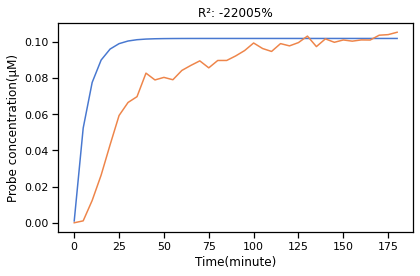

In [24]:
times = np.linspace(0,180,37)

sol_2 = solve_ivp(syst2,t_span =[0, times.max()], y0= z , args =([res_2.x]),
                    t_eval=times,dense_output=True)

m_2 = sol_2.sol(times)
r_2 = r2_score(test_2[test_2.columns[2]],m_2[3])

sns.set_context('notebook')
sns.set_palette("muted")

plt.plot(times,m_2[3])
plt.plot(times,test_2[test_2.columns[1]])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title('R²: '+str(round(r_2*100))+'%')
plt.tight_layout()
#plt.savefig("images/SHERLOCK/modeling/first_attempt.png",dpi=300)
plt.show()